In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="../data_dl" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
#!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root


In [5]:
!file *.root
file = uproot.open("run291694.data.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4

In [6]:
n=0
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge","Muon_E"],how="zip",step_size=10000):
    #Nombre d'évènements avec au moins 2 muons pour chaque lot de 10000 évènements
    #print(len(m),len(m[ak.where(m.nMuons>1)])) 
    n+=len(m[ak.where(m.nMuons>1)])
print("Nombre total d'évènements avec au moins 2 muons : ",n)

Nombre total d'évènements avec au moins 2 muons :  109729


In [7]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [8]:
#CrystalBall2 prend en argument une liste de valeurs de x
def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#CrystalBall2_2 prend en argument une valeur de x
def CrystalBall2_2(i, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
        y = np.exp(-((i-mu)**2)/(2*sigma**2))
    elif ((i-mu)/sigma < alpha):
        y = A*((B- (i -mu)/(sigma))**(-n))
    elif((i-mu)/sigma > alphabis):
        y = C*((D+ (i -mu)/(sigma))**(-nbis))
    return y*N

In [9]:
def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

In [10]:
def CB2withNoise(x, mu_CB2, N_CB2, mu_DE, alpha_DE, beta ,N_DE): #x est une liste
    #alpha,alphabis,n,nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    #return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)
    alpha, alphabis, n, nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    sigma = 6.10076777e-02
    #mu_DE, alpha_DE, beta = 6.29517373e-07, 4.91666545e-01, 1.19404276e-07
    return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)

In [11]:
def scan(dataDescription, 
              hInvMass:hist.Hist, hQualInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """

    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[0:5]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] #selection des évènements CMUL
        tracks = getTracks(events) #on utilise la fonction getTracks définie précédemment
        goodTracks=tracks[trackSelector(tracks)] #selection des évènements (eta, theta et trigger)
        
        #pairs = ak.combinations(goodTracks, 2)
        #one, two = ak.unzip(pairs)
        #rapidity_cut = (abs(one.eta<4)) & (abs(one.eta>2))
        #opposite_charge_cut = (one.charge + two.charge == 0) & (abs(one.eta<2))
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        #invariant_mass = (quality_one + quality_two).mass
        
        pairs = ak.combinations(goodTracks, 2) #toutes les combinaisons de 2 traces
        one, two = ak.unzip(pairs)
        quality_one, quality_two = ak.unzip(pairs[(one.charge + two.charge == 0) & (abs(one.eta) <4) & (abs(one.eta)>2.5) 
                                                 & (abs(two.eta)<4) & (abs(two.eta)>2.5)]) #selection pairs signes opposées et y dans l'acceptance
        invariant_mass = (one + two).mass #masse invariante sans distinction des good pairs
        quality_invariant_mass = (quality_one + quality_two).mass #masse invariante avec correction
    
        hInvMass.fill(ak.flatten(invariant_mass))
        hQualInvMass.fill(ak.flatten(quality_invariant_mass))


        if verbose:
            print(batch[1])

In [12]:
%%time
#Pas de sélection sur les events et tracks
vhInvMass = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass'))
vhQualInvMass = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs'))
#Selection sur les events et tracks
vhInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass'))
vhQualInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs'))


scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hInvMass=vhInvMass, hQualInvMass=vhQualInvMass)

scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hInvMass=vhInvMassEvSel, hQualInvMass=vhQualInvMassEvSel,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<9) & (x["matched"]==2))

CPU times: user 44min 52s, sys: 1min 43s, total: 46min 36s
Wall time: 1h 7min 37s


In [13]:
#Création des listes de valeurs 
x_data=[]
y_data=[]
      
for i in range(15000,50000,175):
    x_data.append(i/10000)

for i in vhQualInvMassEvSel:
      y_data.append(i)

In [19]:
#Fit de la fonction CB2+background avec les listes x_data et y_data pour obtenir mu, N_CB2 et les arguments de noise
%time
popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise, x_data, y_data, p0=[3.1 , 1 , 6.29517373e-07 , 4.91666545e-01 , 1.19404276e-07 , 1],
                    bounds=([3. , 0. , 0. , 0 , 0 , 0.],[3.2 , np.inf , 1 , 1 , 1 , np.inf]))

#popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise, x_data, y_data, p0=[3.10031936e+00, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,1.70816520e+02,
#                    7.18998714e-07,4.91666679e-01,1.36376755e-07,1.57858391e+03])
print(popt_CB2wNoise,pcov_CB2wNoise)
#mu_fitCB2wNoise,sigma_fitCB2wNoise,N_fitCB2wNoise,mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise= popt_CB2wNoise
mu_fitCB2wNoise,N_fitCB2wNoise, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise= popt_CB2wNoise
var_E=pcov_CB2wNoise[0,0]
print('Variance de la masse du JPsi :',var_E)
#y_data_fitCB2wNoise=CB2withNoise(x_data,mu_fitCB2wNoise,sigma_fitCB2wNoise,N_fitCB2wNoise,mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise)
y_data_fitCB2wNoise=CB2withNoise(x_data,mu_fitCB2wNoise,N_fitCB2wNoise, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise)

y_data_model = CB2withNoise(x_data,3.10031936e+00,1.70816520e+02, 6.29517373e-07, 4.91666545e-01, 1.19404276e-07, 1.57858391e+03)
y_CB2_fit = CrystalBall2(x_data,mu_fitCB2wNoise, 6.10076777e-02, -7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise)

y_CB2_fit_2=[]
for i in x_data:
    y_CB2_fit_2.append(CrystalBall2_2(i,mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs
[3.09313009e+00 2.50763219e+04 6.69756554e-01 5.22995224e-01
 1.16592634e-01 1.17757944e+05] [[ 2.30500046e-07 -5.70781978e-04 -3.47449891e-06  7.34702677e-07
  -7.51144887e-07  4.49815424e-01]
 [-5.70781978e-04  1.81526622e+04  1.65517991e+00 -1.30358475e-01
   2.90300520e-01 -2.54216305e+05]
 [-3.47449891e-06  1.65517991e+00  1.31035577e-02 -2.43375482e-03
   2.76504791e-03 -1.77742027e+03]
 [ 7.34702677e-07 -1.30358475e-01 -2.43375482e-03  4.80407428e-04
  -5.20287939e-04  3.23702048e+02]
 [-7.51144887e-07  2.90300520e-01  2.76504791e-03 -5.20287939e-04
   5.85178869e-04 -3.73623170e+02]
 [ 4.49815424e-01 -2.54216305e+05 -1.77742027e+03  3.23702048e+02
  -3.73623170e+02  2.42634253e+08]]
Variance de la masse du JPsi : 2.3050004632728828e-07


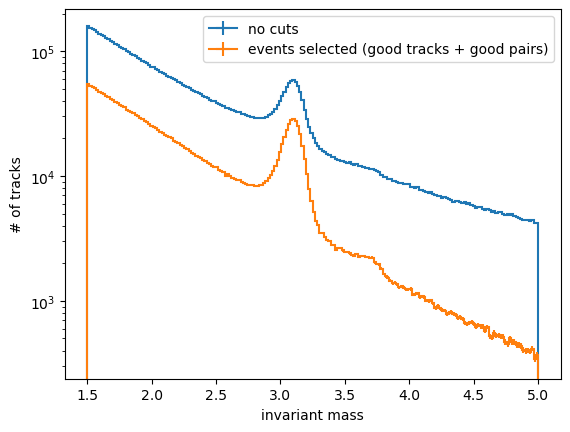

CPU times: user 990 ms, sys: 59.2 ms, total: 1.05 s
Wall time: 1.08 s


In [20]:
%%time
vhInvMass.plot(label="no cuts") #Aucune selection
vhQualInvMassEvSel.plot(label="events selected (good tracks + good pairs)")
#plt.plot(x_data,y_data_model) #Modèle avec les valeurs adéquates pour le fit CB2 MC et le fit background sur une portion des valeurs exp
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.show()

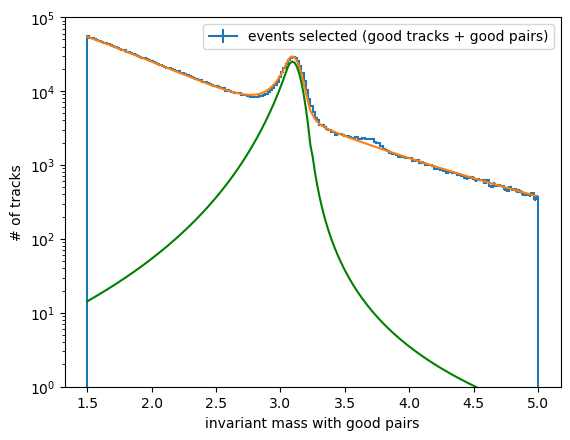

CPU times: user 1.11 s, sys: 67.6 ms, total: 1.17 s
Wall time: 1.18 s


In [21]:
%%time
#vhInvMass.plot(label="no cuts")
vhQualInvMassEvSel.plot(label="events selected (good tracks + good pairs)")
#plt.scatter(x_data,y_data)
plt.plot(x_data,y_data_fitCB2wNoise)
#plt.plot(x_data,y_CB2_fit,'r')
plt.plot(x_data,y_CB2_fit_2,'g')
#plt.plot(x_data,y_data_model)
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.ylim(1,100000)
plt.show()

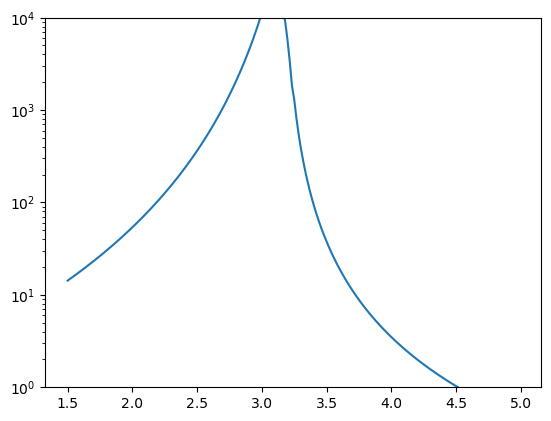

Valeur de l intégrale en utilisant la fonction quad de scipy [2.92257433e+05 3.32458211e-03]
Valeur de l intégrale en utilisant la methodes des rectagnles 292053.1144437062


In [22]:
#I = quad(integrand, 0, 1, args=(a,b))
y_data_finale=[]
for i in x_data:
    y_data_finale.append(CrystalBall2_2(i, mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))
plt.plot(x_data, y_data_finale)
plt.yscale("log")
plt.ylim(1,10000)
plt.show()
    
    
I = quad(CrystalBall2_2,1,5,
        args=(mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))
I = I/vhQualInvMassEvSel.axes[0].widths[0]

print('Valeur de l intégrale en utilisant la fonction quad de scipy',I)

integrale=0
pas=x_data[1]-x_data[0]
for i in range(0,len(x_data)):
    x=pas*i
    integrale = integrale + pas*CrystalBall2_2(x, mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise)

integrale = integrale/vhQualInvMassEvSel.axes[0].widths[0]    
print('Valeur de l intégrale en utilisant la methodes des rectagnles',integrale)
    